In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import os
from pathlib import Path
import warnings
from IPython.display import clear_output

# Get the parent directory and add it to sys.path
parent_dir = Path().resolve().parent
sys.path.append(str(parent_dir))

warnings.filterwarnings("ignore")

from preprocess import pre_xenium
import pandas as pd
import gc

### 1. Preprocess internal data at each time step

In [10]:
import os

root_dir = "../../Jing/0029719"
folders = [folder for folder in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, folder))]
print(folders)
for folder in folders:
    path = os.path.join(root_dir, folder)
    print(path)
    pre_xenium(path)

['12h', '24h', '0h', '4h', '16h', '8h']
../../Jing/0029719/12h


100%|██████████| 469/469 [24:05<00:00,  3.08s/it]


../../Jing/0029719/24h


100%|██████████| 469/469 [20:51<00:00,  2.67s/it]


../../Jing/0029719/0h


100%|██████████| 469/469 [02:30<00:00,  3.12it/s]


../../Jing/0029719/4h


100%|██████████| 469/469 [14:08<00:00,  1.81s/it]


../../Jing/0029719/16h


100%|██████████| 469/469 [21:25<00:00,  2.74s/it]


../../Jing/0029719/8h


100%|██████████| 469/469 [16:26<00:00,  2.10s/it]


### 2. Generate training sets

In [37]:
from data_builder import TimeSeriesBuilder, read_trans, read_labels

# load transcripts and cell 
root_dir = "../../Jing/0029719/"
time_points = ['0h', '4h', '8h', '12h', '16h', '24h']
for time_point in time_points:
    folder = root_dir + time_point + '/'
    save_path = os.path.join(folder, 'TimeSeries/')
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    cell_types = read_labels(filename=folder + 'clusters.csv')
    gene_list = sorted([f[:-4] for f in os.listdir(folder+'MoleculesPerGene') if f.endswith('.csv')])
    for i in range(len(gene_list)):
        gene = gene_list[i]
        clear_output(wait=True)
        print(f'Processing the {i+1}-th gene: {gene}')
        transcripts = read_trans(folder + 'MoleculesPerGene/' + gene + '.csv')
        num_cells = transcripts['cell_id'].nunique()
        # Build time series
        tsb = TimeSeriesBuilder(transcripts, cell_types)
        tsb.run(num_samples=int(num_cells/10), save_path=save_path, gene=gene)

Processing the 469-th gene: ZC3HAV1
Building cell dictionaries
Build cell feature vectors
Find spatial neighbors
Calculate random walk transition probabilities
Start building the dataset


100%|██████████| 689/689 [00:00<00:00, 13506.49it/s]

689 time-series samples of ZC3HAV1 generated


### 3. Training for each gene

In [8]:
from utils import read_data, set_seed, heuristic_alpha, heuristic_alpha2
from models import Model
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from training import train, test
from tqdm import tqdm

# Set parameters
SEQ_LEN = 10
dim_inputs = 10
hidden_size = 50
latent_size = 50

batch_size = 1024
base_lr = 0.01
lr_step = 10
num_epochs = 100

In [23]:
root_dir = "../../Jing/0029719/"
time_points = ['0h', '4h', '8h', '12h', '16h', '24h']
for time_point in time_points:
    folder = root_dir + time_point + '/'
    data_folder = folder + 'TimeSeries/'
    model_folder = folder + 'Models/'
    molecules_folder = folder + 'MoleculesPerGene/'
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)    
    # Fetch the list of genes
    gene_list = [f.split('_')[0] for f in os.listdir(data_folder) if f.endswith('.csv')]
    # Remove duplicates
    gene_list = sorted(list(set(gene_list)))

    for i in range(len(gene_list)):
        gene = gene_list[i]
        clear_output(wait=True)
        print(f'Training gene: {gene}')
        # data loading and training
        data_path = data_folder + gene + '_data.csv'
        locs_path = data_folder + gene + '_locs.csv'
        data, locs = read_data(data_path, locs_path, SEQ_LEN, dim_inputs)
        training_size = int(data.shape[0] * 0.8)  # 80% of the data is used for training
        train_data = data[:training_size]
        train_locs = locs[:training_size]
        set_seed(42)
        alpha = heuristic_alpha(molecules_folder + gene + '.csv') / 3
        # alpha = heuristic_alpha2(train_data)
        print(f'alpha: {alpha}')
        net, _, _ = train(train_data, train_locs, alpha, batch_size, base_lr, lr_step, num_epochs, hidden_size, latent_size, SEQ_LEN)
        # save the trained model
        torch.save(net.state_dict(), model_folder + gene + '_model.pth')

Training gene: ZC3HAV1
alpha: 0.12136484461843315


Training: 100%|██████████| 100/100 [00:02<00:00, 43.63it/s]


### 4. Test for each gene and save velos

In [24]:
root_dir = "../../Jing/0029719/"
time_points = ['0h', '4h', '8h', '12h', '16h', '24h']
for time_point in time_points:
    folder = root_dir + time_point + '/'
    data_folder = folder + 'TimeSeries/'
    model_folder = folder + 'Models/'
    velos_floder = folder + 'velos/'
    if not os.path.exists(velos_floder):
        os.makedirs(velos_floder)  
    # Fetch the list of genes
    gene_list = [f.split('_')[0] for f in os.listdir(data_folder) if f.endswith('.csv')]
    # Remove duplicates
    gene_list = sorted(list(set(gene_list)))

    for gene in tqdm(gene_list, desc='Testing'):
        # load full dataset for better distribution estimation
        data_path = data_folder + gene + '_data.csv'
        locs_path = data_folder + gene + '_locs.csv'
        data, locs = read_data(data_path, locs_path, SEQ_LEN, dim_inputs)
        test_data = data
        test_locs = locs
        # load the trained model and start test
        model_path = model_folder + gene + '_model.pth'
        net = Model(dim_inputs, hidden_size, latent_size, SEQ_LEN)
        net.load_state_dict(torch.load(model_path))
        prediction, generation, trans_status, loss_recon = test(test_data, test_locs, net)
        
        # get velos and save
        rows = []
        for i in range(len(generation)):
            gen = generation[i].view(-1).cpu().detach().numpy()
            status = trans_status[i].view(-1).cpu().detach().numpy()
            velo = gen * status
            rows.append(velo)
        output_df = pd.DataFrame(rows)
        output_df.to_csv(velos_floder + f"{gene}_velos.csv", index=False, header=False)
        torch.cuda.empty_cache() 
        gc.collect()


Testing: 100%|██████████| 69/69 [00:07<00:00,  9.67it/s]


### 5. Analysis

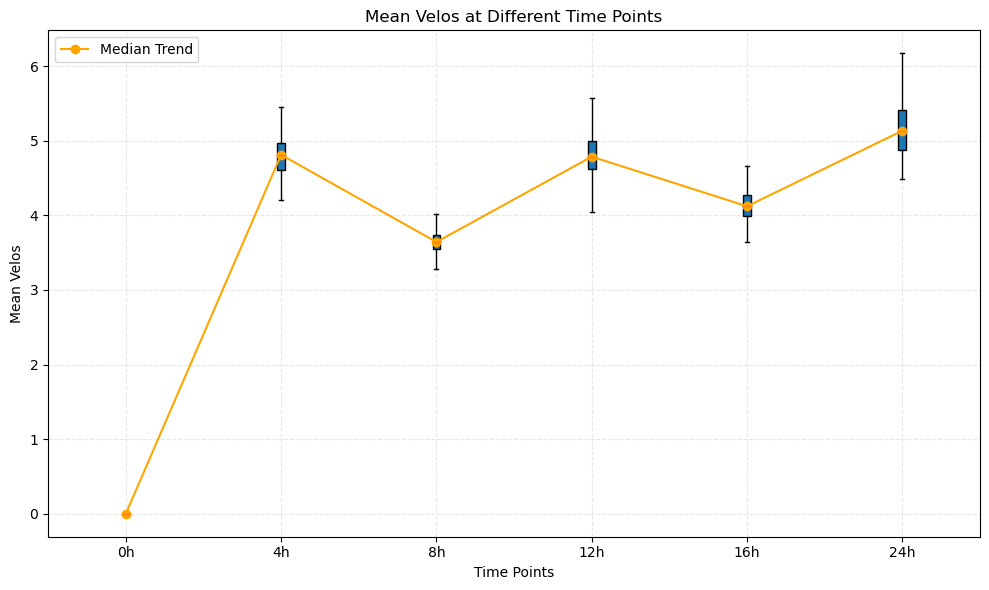

In [38]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

root_dir = "../../Jing/0029719/"
time_points = ['0h', '4h', '8h', '12h', '16h', '24h']
mean_velos = []
var_velos = []

for time_point in time_points:
    velos_file = os.path.join(root_dir, time_point, 'velos', f"{gene}_velos.csv")
    velos_df = pd.read_csv(velos_file, header=None)
    mean_velo = velos_df.mean(axis=1)
    var_velo = velos_df.var(axis=1)
    mean_velos.append(mean_velo)
    var_velos.append(var_velo)

# Prepare medians for overlay
medians = [mv.median() for mv in mean_velos]

# Plotting
plt.figure(figsize=(10, 6))
box = plt.boxplot(mean_velos, labels=time_points, widths=0.05, patch_artist=True, showfliers=False)

# Overlay line connecting medians
plt.plot(range(1, len(time_points)+1), medians, marker='o', linestyle='-', color='orange', label='Median Trend')

# Labels and title
plt.xlabel('Time Points')
plt.ylabel('Mean Velos')
plt.title('Mean Velos at Different Time Points')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


[Warning] File not found: ../../Jing/0029719/0h/velos/IFI16_velos.csv — using zeros instead.


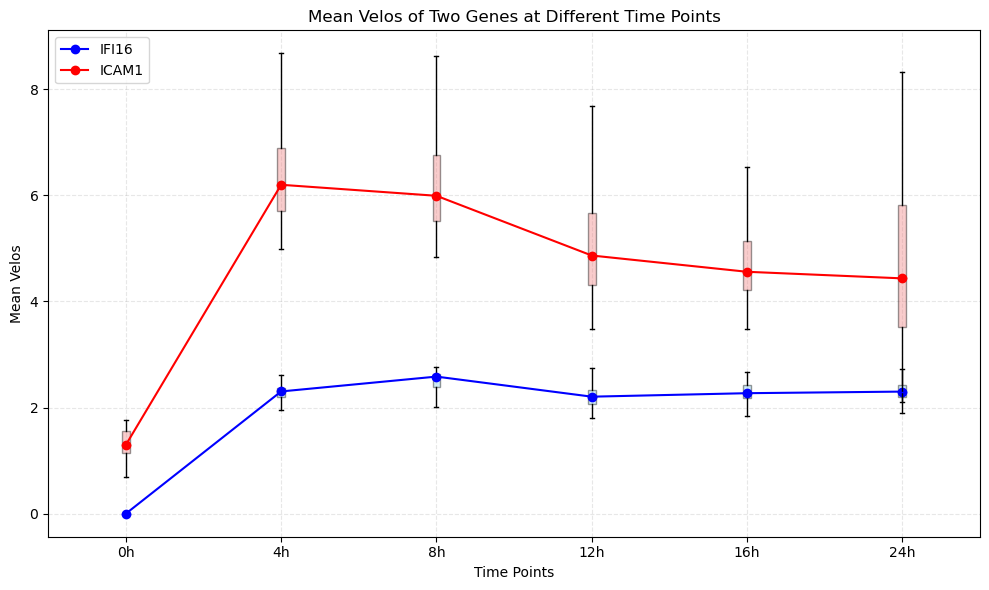

In [54]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

root_dir = "../../Jing/0029719/"
time_points = ['0h', '4h', '8h', '12h', '16h', '24h']
genes = ['IFI16', 'ICAM1']
colors = ['skyblue', 'lightcoral']
line_colors = ['blue', 'red']
fallback_length = 100  # Default length of zero array if file is missing

plt.figure(figsize=(10, 6))

for idx, gene in enumerate(genes):
    mean_velos = []
    for time_point in time_points:
        velos_file = os.path.join(root_dir, time_point, 'velos', f"{gene}_velos.csv")
        if os.path.exists(velos_file):
            velos_df = pd.read_csv(velos_file, header=None)
            mean_velo = velos_df.mean(axis=1)
        else:
            print(f"[Warning] File not found: {velos_file} — using zeros instead.")
            mean_velo = pd.Series(np.zeros(fallback_length))
        mean_velos.append(mean_velo)

    # Plot boxplot
    plt.boxplot(
        mean_velos,
        positions=range(1, len(time_points)+1),
        widths=0.05,
        patch_artist=True,
        boxprops=dict(facecolor=colors[idx], alpha=0.4),
        medianprops=dict(color=line_colors[idx]),
        showfliers=False
    )

    # Overlay median curve
    medians = [mv.median() for mv in mean_velos]
    plt.plot(range(1, len(time_points)+1), medians, marker='o', linestyle='-', color=line_colors[idx], label=gene)

# Final formatting
plt.xlabel('Time Points')
plt.ylabel('Mean Velos')
plt.title('Mean Velos of Two Genes at Different Time Points')
plt.xticks(ticks=range(1, len(time_points)+1), labels=time_points)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [55]:
file = '../../Jing/0029719/tf_gene_pairs.csv'
tf_gene_pairs = pd.read_csv(file)

In [57]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

root_dir = "../../Jing/0029719/"
figures_dir = os.path.join(root_dir, "figures")
os.makedirs(figures_dir, exist_ok=True)

time_points = ['0h', '4h', '8h', '12h', '16h', '24h']
colors = ['skyblue', 'lightcoral']
line_colors = ['blue', 'red']
fallback_length = 100  # Number of zeros to use when file is missing

# Loop over each TF-Gene pair
for i in range(len(tf_gene_pairs)):
    tf = tf_gene_pairs.iloc[i]['TF']
    gene = tf_gene_pairs.iloc[i]['Gene']
    genes = [tf, gene]

    plt.figure(figsize=(10, 6))

    for idx, g in enumerate(genes):
        mean_velos = []
        for time_point in time_points:
            velos_file = os.path.join(root_dir, time_point, 'velos', f"{g}_velos.csv")
            if os.path.exists(velos_file):
                velos_df = pd.read_csv(velos_file, header=None)
                mean_velo = velos_df.mean(axis=1)
            else:
                print(f"[Warning] File not found: {velos_file} — using zeros instead.")
                mean_velo = pd.Series(np.zeros(fallback_length))
            mean_velos.append(mean_velo)

        # Plot boxplot
        plt.boxplot(
            mean_velos,
            positions=range(1, len(time_points)+1),
            widths=0.05,
            patch_artist=True,
            boxprops=dict(facecolor=colors[idx], alpha=0.4),
            medianprops=dict(color=line_colors[idx]),
            showfliers=False
        )

        # Overlay median curve
        medians = [mv.median() for mv in mean_velos]
        plt.plot(range(1, len(time_points)+1), medians, marker='o', linestyle='-', color=line_colors[idx], label=g)

    # Final formatting
    plt.xlabel('Time Points')
    plt.ylabel('Mean Velos')
    plt.title(f'Mean Velos: {tf} and {gene}')
    plt.xticks(ticks=range(1, len(time_points)+1), labels=time_points)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()

    # Save the figure
    fig_filename = f"{tf}_{gene}.png"
    fig_path = os.path.join(figures_dir, fig_filename)
    plt.savefig(fig_path)
    plt.close()


[Warning] File not found: ../../Jing/0029719/0h/velos/ETV7_velos.csv — using zeros instead.
[Warning] File not found: ../../Jing/0029719/0h/velos/IFI16_velos.csv — using zeros instead.
[Warning] File not found: ../../Jing/0029719/0h/velos/ETV7_velos.csv — using zeros instead.
[Warning] File not found: ../../Jing/0029719/0h/velos/IL6_velos.csv — using zeros instead.
[Warning] File not found: ../../Jing/0029719/0h/velos/CIITA_velos.csv — using zeros instead.
[Warning] File not found: ../../Jing/0029719/0h/velos/IFIT3_velos.csv — using zeros instead.
[Warning] File not found: ../../Jing/0029719/0h/velos/IL6_velos.csv — using zeros instead.
[Warning] File not found: ../../Jing/0029719/0h/velos/SOCS1_velos.csv — using zeros instead.
[Warning] File not found: ../../Jing/0029719/4h/velos/SOCS1_velos.csv — using zeros instead.
[Warning] File not found: ../../Jing/0029719/8h/velos/SOCS1_velos.csv — using zeros instead.
[Warning] File not found: ../../Jing/0029719/12h/velos/SOCS1_velos.csv — usi